<a href="https://colab.research.google.com/github/datarae/deeplearning/blob/main/Liquid_Neural_Networks_Comparison_with_Stock_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPARISON OF NEURAL NETWORKS**
**Created by Rae Chipera**

**Director of Machine Learning**

**Jaxorik AI Research Group**

www.jaxorik.com

The purpose of this project is to compare the performance of different neural networks with same data. This will show us how neural network technology has improved over time.

Since we need a large dataset that anyone can use, we will use stock data.

This notebook should not be considered investing advice. It's just a notebook designed to show the performance of neural networks, and is for educational use only.

First, we will look at a Recurrent Neural Network (RNN).

Next, we will use a transformer-based neural network (TNN).

Last, we will use a liquid neural network (LNN).




## **Import & Clean the Datasets**
We will use several large datasets to look at these algorithms.




### **S&P 500 ETF**

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Define stock symbol and date range
symbol = "SPY" #The ETF that tracks the S&P 500 Index
start_date = "2000-01-01"
end_date = "2023-12-31"

#Download the data
data = yf.download(symbol, start=start_date, end=end_date)

#Extract the closing prices
close_prices = data["Close"].values

[*********************100%***********************]  1 of 1 completed


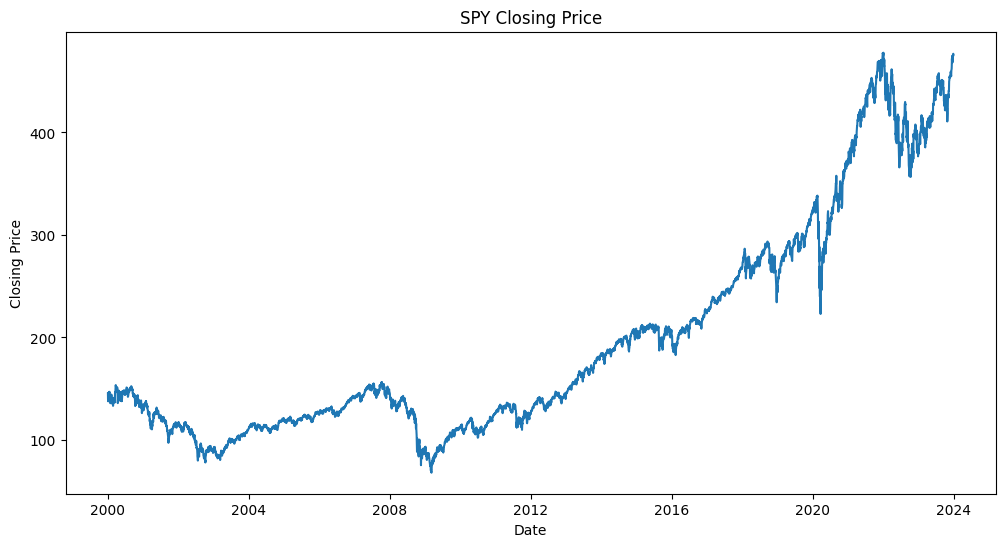

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, close_prices)
plt.title(f"{symbol} Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [4]:
#Normalize the data
close_prices_normalized = (close_prices - close_prices.min()) / (close_prices.max() - close_prices.min())

In [5]:
#Split the data into training and testing sets
split_index = int(0.8 * len(close_prices_normalized))
train_data = close_prices_normalized[:split_index]
test_data = close_prices_normalized[split_index:]

## **Recurrent Neural Network (RNN)**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
#Define the RNN model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #Initialize the hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        #Forward propigation through the RNN
        out, _ = self.rnn(x, h0)

        #Only the last output for the prediction
        out = self.fc(out[:, -1, :])
        return out

### **Format the Data**

In [8]:
#Set up the model, loss, and optimizer
model = StockPriceRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
#Normalize stock prices using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

#Convert the data into sequences
sequence_length = 10  # Defined at the start
X_rnn, Y_rnn = [], []
for i in range(len(scaled_data) - sequence_length):
    X_rnn.append(scaled_data[i:i+sequence_length])
    Y_rnn.append(scaled_data[i+sequence_length])

X_rnn_stocks = torch.tensor(X_rnn, dtype = torch.float32)
Y_rnn_stocks = torch.tensor(Y_rnn, dtype = torch.float32)

#Train Test Split
split_index = int(0.8 * len(X_rnn_stocks))
X_train_stocks, X_test_stocks = X_rnn_stocks[:split_index], X_rnn_stocks[split_index:]
Y_train_stocks, Y_test_stocks = Y_rnn_stocks[:split_index], Y_rnn_stocks[split_index:]

### **Train the RNN**

In [10]:
#Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_stocks)
    loss = criterion(outputs, Y_train_stocks)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0196
Epoch [20/100], Loss: 0.0130
Epoch [30/100], Loss: 0.0095
Epoch [40/100], Loss: 0.0067
Epoch [50/100], Loss: 0.0033
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


In [11]:
RNN_predictions_stocks = model(X_test_stocks)

### **Test the Model**

In [14]:
# Get the corresponding date range for the test data
test_dates = data.index[split_index + sequence_length:]  # Align with actual_prices length

#De-normalize predictions for comparison with actual values
predicted_prices = RNN_predictions_stocks * (close_prices.max() - close_prices.min()) + close_prices.min()

# Adjust the slicing of actual_prices to match the length of predicted_prices
actual_prices = close_prices[split_index + 1:split_index + 1 + len(predicted_prices)]

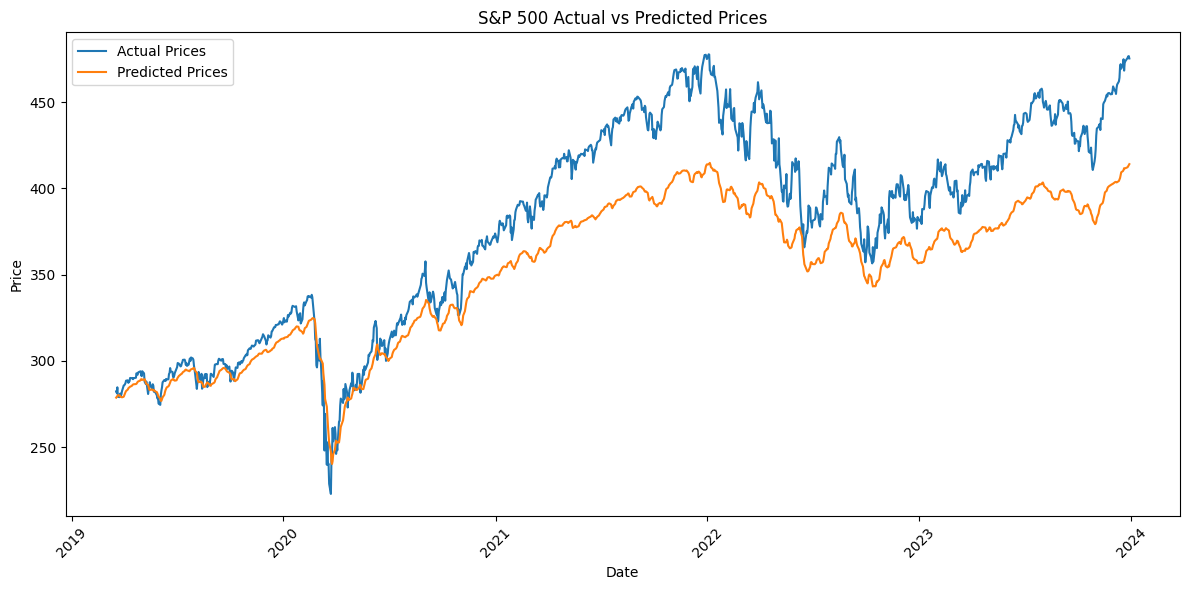

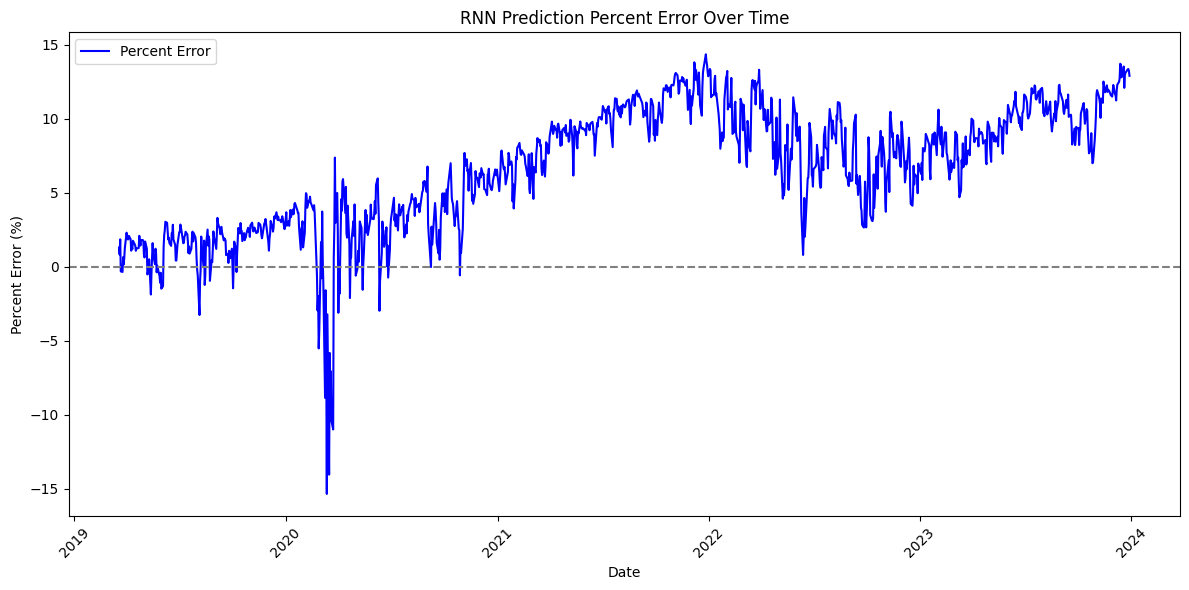

Shapes before flattening:
predicted_prices shape: (1206, 1)
actual_prices shape: (1206, 1)

Shapes after flattening:
percent_error shape: (1206,)


In [19]:
# First detach and convert to numpy, then denormalize the predictions
predicted_prices = RNN_predictions_stocks.detach().numpy() * (close_prices.max() - close_prices.min()) + close_prices.min()

# Then align dates and actual prices correctly
test_dates = data.index[split_index + sequence_length:split_index + sequence_length + len(predicted_prices)]
actual_prices = close_prices[split_index + sequence_length:split_index + sequence_length + len(predicted_prices)]

# Validate lengths match
assert len(test_dates) == len(predicted_prices) == len(actual_prices), "Length mismatch in test data"

# Now plot with correctly aligned data
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, label="Actual Prices")
plt.plot(test_dates, predicted_prices, label="Predicted Prices")
plt.title("S&P 500 Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and plot percent error
predicted_prices_flat = predicted_prices.squeeze().flatten()  # Ensure 1D array
actual_prices_flat = actual_prices.squeeze().flatten()  # Ensure 1D array
percent_error = (actual_prices_flat - predicted_prices_flat) / actual_prices_flat * 100

plt.figure(figsize=(12, 6))
plt.plot(test_dates, percent_error, 'b-', label="Percent Error")  # 'b-' specifies blue line
plt.title("RNN Prediction Percent Error Over Time")
plt.xlabel("Date")
plt.ylabel("Percent Error (%)")
plt.axhline(0, color="gray", linestyle="--")  # Reference line at 0
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Let's print the shapes to verify our data
print("Shapes before flattening:")
print(f"predicted_prices shape: {predicted_prices.shape}")
print(f"actual_prices shape: {actual_prices.shape}")
print("\nShapes after flattening:")
print(f"percent_error shape: {percent_error.shape}")

**Observations:** This does not fit within 2 standard deviations, so this model would not be acceptable.

Before 2020, the model tended to over-estimate the next price of the stock market. However, after 2020, the model is significantly under-estimating the price.

We can play with the model a bit to make it more or less accurate, but it has not been able to hit an acceptable confidence interval.

## **Transformer-Based Neural Network**

Now, we will have to do a few extra steps because PyTorch's nn.Transfomer module expects a 3D input of shapes, and we are currently using a 4D tensor.

In [27]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=8, num_layers=3, output_size=1, max_seq_len=100):
        super(TransformerTimeSeries, self).__init__()
        self.d_model = d_model

        # Input embedding
        self.embedding = nn.Linear(input_size, d_model)

        # Positional encoding
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_seq_len, d_model]

        # Transformer layers
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True  # This makes input shape (batch, seq, feature)
        )
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output layer
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]

        # Embed input sequence
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x * math.sqrt(self.d_model)

        # Add positional encoding
        x = x + self.pe[:, :x.size(1), :]

        # Transformer encoder
        x = self.transformer(x)  # [batch_size, seq_len, d_model]

        # Get prediction from last time step
        x = self.fc(x[:, -1, :])  # [batch_size, output_size]

        return x

In [28]:
import math

# Create sequences for transformer
X_transformer, Y_transformer = [], []
for i in range(len(scaled_data) - sequence_length):
    X_transformer.append(scaled_data[i:i+sequence_length])
    Y_transformer.append(scaled_data[i+sequence_length])

# Convert to tensors with correct shape
# Shape should be (batch_size, sequence_length, input_size)
X_transformer = torch.tensor(X_transformer, dtype=torch.float32).unsqueeze(-1)  # Only unsqueeze once
Y_transformer = torch.tensor(Y_transformer, dtype=torch.float32).unsqueeze(-1)

# Print shapes to verify
print(f"X_transformer shape: {X_transformer.shape}")  # Should be (num_samples, sequence_length, 1)
print(f"Y_transformer shape: {Y_transformer.shape}")  # Should be (num_samples, 1)

# Split into training and testing sets
split_index = int(0.8 * len(X_transformer))
X_train, X_test = X_transformer[:split_index], X_transformer[split_index:]
Y_train, Y_test = Y_transformer[:split_index], Y_transformer[split_index:]

# Initialize model with correct parameters
model = TransformerTimeSeries(
    input_size=1,  # Single feature (price)
    d_model=64,    # Embedding dimension
    nhead=8,       # Number of attention heads
    num_layers=3,  # Number of transformer layers
    output_size=1, # Single output (predicted price)
    max_seq_len=sequence_length  # Maximum sequence length
)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_transformer shape: torch.Size([6027, 10, 1, 1])
Y_transformer shape: torch.Size([6027, 1, 1])


In [29]:
# Create sequences for transformer
X_transformer, Y_transformer = [], []
for i in range(len(scaled_data) - sequence_length):
    X_transformer.append(scaled_data[i:i+sequence_length])
    Y_transformer.append(scaled_data[i+sequence_length])

print("After list creation:")
print(f"X_transformer first element shape: {np.array(X_transformer[0]).shape}")

# Convert to tensors - let's do this step by step
X_transformer = torch.tensor(X_transformer, dtype=torch.float32)
print("\nAfter initial tensor conversion:")
print(f"X_transformer shape: {X_transformer.shape}")

Y_transformer = torch.tensor(Y_transformer, dtype=torch.float32)
print(f"Y_transformer shape: {Y_transformer.shape}")

# Split into training and testing sets
split_index = int(0.8 * len(X_transformer))
X_train, X_test = X_transformer[:split_index], X_transformer[split_index:]
Y_train, Y_test = Y_transformer[:split_index], Y_transformer[split_index:]

print("\nAfter splitting:")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

After list creation:
X_transformer first element shape: (10, 1)

After initial tensor conversion:
X_transformer shape: torch.Size([6027, 10, 1])
Y_transformer shape: torch.Size([6027, 1])

After splitting:
X_train shape: torch.Size([4821, 10, 1])
Y_train shape: torch.Size([4821, 1])


### **Train the TNN**

This will blue screen your laptop. You may want to run this while connected to a GPU via Google Colab.

In [30]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create DataLoader for batch processing
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        # Move batch to GPU
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training completed!")

Epoch [10/50], Average Loss: 0.0003
Epoch [20/50], Average Loss: 0.0002
Epoch [30/50], Average Loss: 0.0001
Epoch [40/50], Average Loss: 0.0001
Epoch [50/50], Average Loss: 0.0001
Training completed!


### **Test the Model**

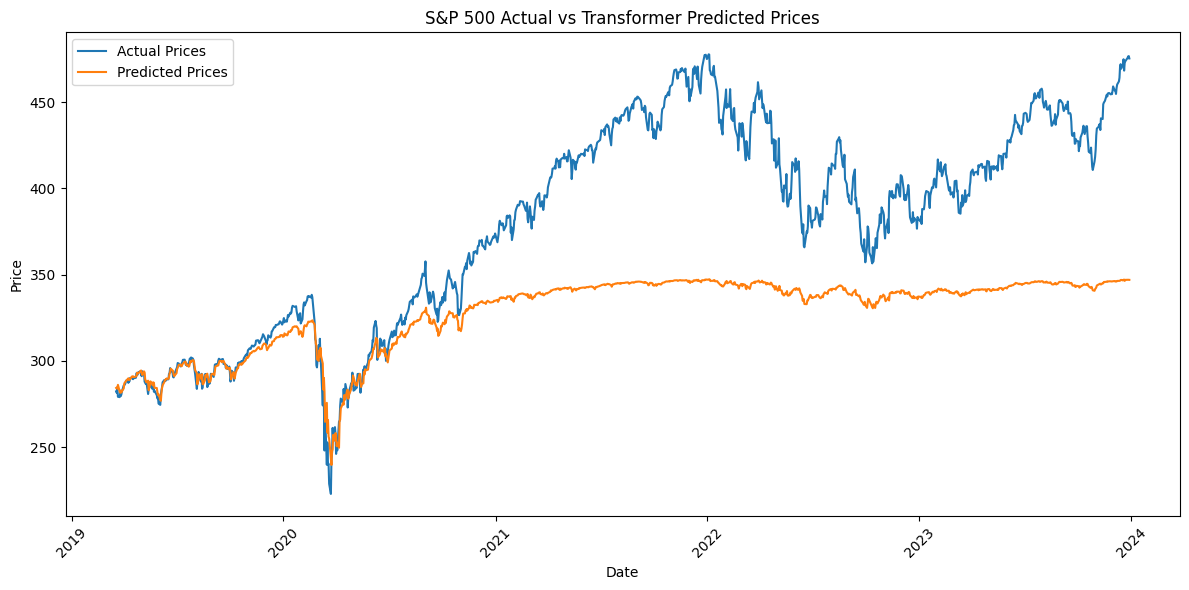

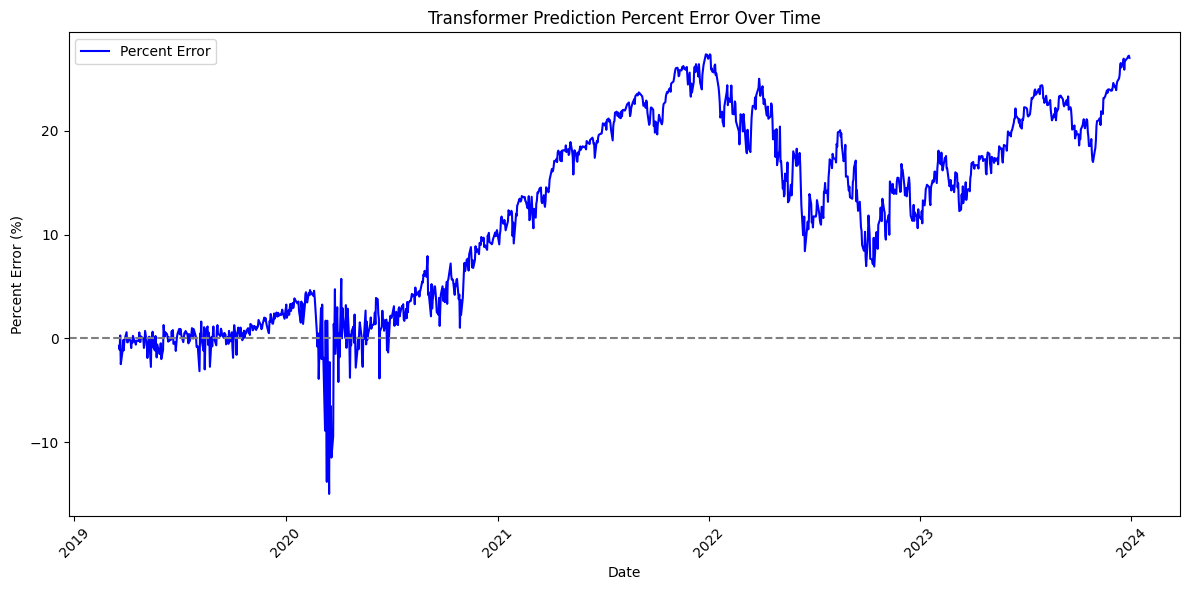

Mean Squared Error: 4325.010146040536


In [32]:
# Evaluation mode
model.eval()
with torch.no_grad():
    # Get predictions
    predictions = model(X_test.to(device))
    predictions = predictions.cpu().numpy()  # Move back to CPU and convert to numpy

# First denormalize the predictions
predicted_prices = predictions * (close_prices.max() - close_prices.min()) + close_prices.min()

# Then align dates and actual prices correctly
test_dates = data.index[split_index + sequence_length:split_index + sequence_length + len(predicted_prices)]
actual_prices = close_prices[split_index + sequence_length:split_index + sequence_length + len(predicted_prices)]

# Ensure 1D arrays for plotting
predicted_prices_flat = predicted_prices.squeeze().flatten()  # Ensure 1D array
actual_prices_flat = actual_prices.squeeze().flatten()  # Ensure 1D array

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices_flat, label="Actual Prices")
plt.plot(test_dates, predicted_prices_flat, label="Predicted Prices")
plt.title("S&P 500 Actual vs Transformer Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and plot percent error
percent_error = (actual_prices_flat - predicted_prices_flat) / actual_prices_flat * 100

plt.figure(figsize=(12, 6))
plt.plot(test_dates, percent_error, 'b-', label="Percent Error")
plt.title("Transformer Prediction Percent Error Over Time")
plt.xlabel("Date")
plt.ylabel("Percent Error (%)")
plt.axhline(0, color="gray", linestyle="--")  # Reference line at 0
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print MSE for comparison with other models
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_prices_flat, predicted_prices_flat)
print(f"Mean Squared Error: {mse}")

**Observation:** Well... that's awful.

We can play with the number of epochs a few times, but it never seems to get better.

## **Liquid Neural Network**

In [33]:
from sklearn.linear_model import Ridge

In [35]:
class LiquidNeuralNetwork:
    def __init__(self, input_size, reservoir_size, spectral_radius=0.95, sparsity=0.1, leaking_rate=1.0):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.leaking_rate = leaking_rate

        # Initialize input weights with better scaling
        self.W_in = (np.random.rand(reservoir_size, input_size) * 2 - 1) * 0.1

        # Initialize reservoir weights with better scaling
        self.W_res = np.random.rand(reservoir_size, reservoir_size) * 2 - 1

        # Add bias
        self.W_bias = (np.random.rand(reservoir_size, 1) * 2 - 1) * 0.1

        # Scale reservoir weights by spectral radius
        eigenvalues = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res *= spectral_radius / eigenvalues

        # Sparsify reservoir weights
        mask = np.random.rand(reservoir_size, reservoir_size) > sparsity
        self.W_res *= mask

        self.state = np.zeros((reservoir_size, 1))
        self.readout_weights = None

    def reset_state(self):
        """Reset the reservoir state to zero."""
        self.state = np.zeros((reservoir_size, 1))

    def forward(self, input_data):
        """
        Perform one forward step.
        Args:
            input_data: numpy array of shape (input_size,)
        Returns:
            reservoir state after update
        """
        input_data = np.array(input_data).reshape(-1, 1)
        if input_data.shape[0] != self.input_size:
            raise ValueError(f"Input size mismatch. Expected {self.input_size}, got {input_data.shape[0]}")

        # Calculate new state with leaking rate
        next_state = np.tanh(
            np.dot(self.W_in, input_data) +
            np.dot(self.W_res, self.state) +
            self.W_bias
        )
        self.state = (1 - self.leaking_rate) * self.state + self.leaking_rate * next_state
        return self.state

    def train_readout(self, X, Y, alpha=1e-5):
        """
        Train the readout layer using Ridge regression.
        Args:
            X: Training states matrix of shape (n_samples, reservoir_size)
            Y: Target values of shape (n_samples, output_size)
            alpha: Ridge regression regularization parameter
        """
        if len(X) != len(Y):
            raise ValueError(f"X and Y must have same length. Got X: {len(X)}, Y: {len(Y)}")

        ridge = Ridge(alpha=alpha, fit_intercept=True)
        ridge.fit(X, Y)
        self.readout_weights = ridge.coef_
        self.readout_bias = ridge.intercept_

    def predict(self, X):
        """
        Predict using trained readout weights.
        Args:
            X: States matrix of shape (n_samples, reservoir_size)
        Returns:
            Predictions of shape (n_samples, output_size)
        """
        if self.readout_weights is None:
            raise ValueError("Model not trained. Call train_readout first.")

        return np.dot(X, self.readout_weights.T) + self.readout_bias

    def warmup(self, data, n_warmup):
        """
        Warm up the reservoir with initial data points.
        Args:
            data: Warmup data of shape (n_warmup, input_size)
            n_warmup: Number of warmup steps
        """
        self.reset_state()
        for i in range(min(n_warmup, len(data))):
            self.forward(data[i])

**Note:**

*   The **forward** function updates the reservoir state using the input and internal weights
*   In **train_readout,** the final reservoir states are collected as inputs (X) to train a linear regression model against the target output (Y).


### **Test the Model**

Shapes before training:
reservoir_states shape: (4829, 100)
train_data shape: (4829, 1)

Shapes for testing:
test_states shape: (1208, 100)
predictions shape: (1208, 1)
test_data shape: (1208, 1)


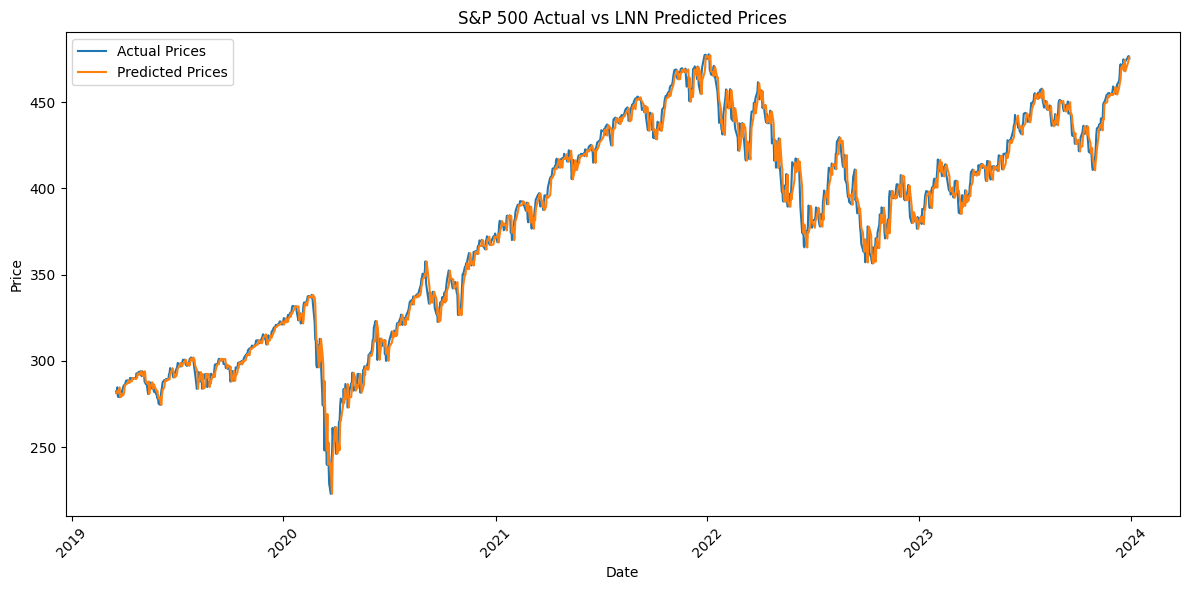

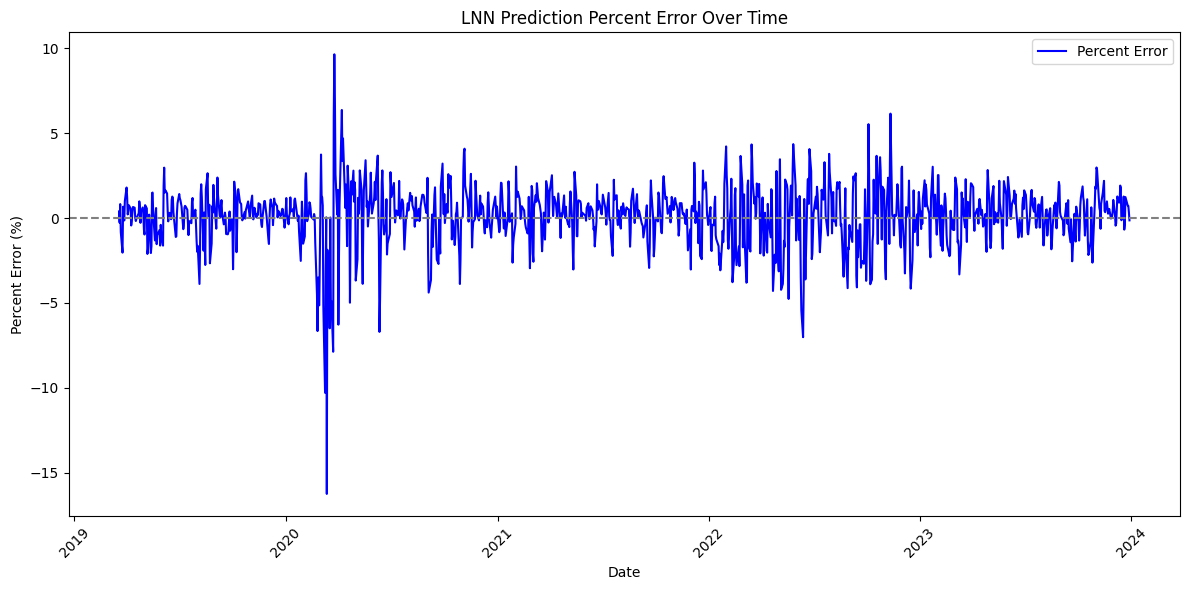


Mean Squared Error: 38.81443769143665


In [39]:
# Initialize the LNN
input_size = 1  # Single feature (price)
reservoir_size = 100  # Size of the reservoir
lnn = LiquidNeuralNetwork(input_size, reservoir_size)

# Collect reservoir states for training data
reservoir_states = []
for point in train_data:
    state = lnn.forward(np.array([point]))
    reservoir_states.append(state.flatten())

reservoir_states = np.array(reservoir_states)

print("Shapes before training:")
print(f"reservoir_states shape: {reservoir_states.shape}")
print(f"train_data shape: {train_data.shape}")

# Ensure same lengths for training
min_length = min(len(reservoir_states), len(train_data))
reservoir_states = reservoir_states[:min_length]
train_data_aligned = train_data[:min_length]

# Train the readout layer
lnn.train_readout(reservoir_states, train_data_aligned)

# Generate test predictions
test_states = []
for point in test_data:
    state = lnn.forward(np.array([point]))
    test_states.append(state.flatten())

test_states = np.array(test_states)
predictions = lnn.predict(test_states)

# Print shapes for debugging
print("\nShapes for testing:")
print(f"test_states shape: {test_states.shape}")
print(f"predictions shape: {predictions.shape}")
print(f"test_data shape: {test_data.shape}")

# Denormalize predictions
predicted_prices = predictions * (close_prices.max() - close_prices.min()) + close_prices.min()

# Align dates and actual prices correctly
test_dates = data.index[split_index + sequence_length:split_index + sequence_length + len(predicted_prices)]
actual_prices = close_prices[split_index + sequence_length:split_index + sequence_length + len(predicted_prices)]

# Ensure 1D arrays for plotting
predicted_prices_flat = predicted_prices.squeeze().flatten()  # Ensure 1D array
actual_prices_flat = actual_prices.squeeze().flatten()  # Ensure 1D array

# Ensure same lengths for plotting
min_length = min(len(test_dates), len(actual_prices_flat), len(predicted_prices_flat))
test_dates = test_dates[:min_length]
actual_prices_flat = actual_prices_flat[:min_length]
predicted_prices_flat = predicted_prices_flat[:min_length]

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices_flat, label="Actual Prices")
plt.plot(test_dates, predicted_prices_flat, label="Predicted Prices")
plt.title("S&P 500 Actual vs LNN Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and plot percent error
percent_error = (actual_prices_flat - predicted_prices_flat) / actual_prices_flat * 100

plt.figure(figsize=(12, 6))
plt.plot(test_dates, percent_error, 'b-', label="Percent Error")
plt.title("LNN Prediction Percent Error Over Time")
plt.xlabel("Date")
plt.ylabel("Percent Error (%)")
plt.axhline(0, color="gray", linestyle="--")  # Reference line at 0
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print MSE for comparison with other models
mse = mean_squared_error(actual_prices_flat, predicted_prices_flat)
print(f"\nMean Squared Error: {mse}")

**Observations:** The LNN model does a fantastic job of predicting the prices, admittedly a few days ahead of time. The majority of the predictions are within 2 standard deviations, which would make this model almost acceptable.

If we were to remove March and April of 2020 as an outlier, the data is even closer to being acceptable.

**Note:** Please do not use this for investing. This is for educational purposes only. Any investment algorithm needs A LOT more testing than one backtest before it is implemented.